# Vancouver Takeoff Data Source Code

## Imports

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import math
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
import time
from scipy.stats import linregress


## File Readings and Dataframe Creation

In [15]:
%%time
# Flights from Apr 16 to May 23
colormap = plt.colormaps['tab20']
subfolders = [f.path for f in os.scandir('data/vancouver/flight/') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
soh_list1 = []
soh_list2 = []
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []
df_pitch_list = []
df_roll_list = []
df_speed_list = []
df_soh_list = []
df_battT_list = []
power_sum = [0,0,0]
time_sum = [0,0,0]

# df_Dtime_list = []
# df_Dkw_list = []
# df_Dalt_list = []
# df_Dsoc_list = []
# df_Doat_list = []
# df_Dpitch_list = []
# df_Droll_list = []
# df_Dspeed_list = []

# Iterates and read each csv
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    if csv_files:
        # Reads the first csv file in each flight folder
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        # Skips every 10 rows for efficiency (1 sec iterations estimate)
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_soh = (df_csv[' bat 1 soh'] + df_csv[' bat 2 soh']) / 2
    df_soh_list.append(df_soh)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    df_pitch_list.append(df_csv[" PITCH"])
    df_roll_list.append(df_csv[" ROLL"])
    df_speed_list.append(df_csv[" GROUND_SPEED"])

    df_battT = 0
    for i in range(1, 17):
        df_battT += df_csv[f" bat 1 cell {i} temp"] 
        df_battT += df_csv[f" bat 2 cell {i} temp"] 
    df_battT = df_battT/32 
    df_battT_list.append(df_battT)
    
    
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
# for i, subfolder in enumerate(derated):
#     csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
#     print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
#     if csv_files:
#         # Reads the first csv file in each flight folder
#         main_csv = csv_files[0]
#         with open(main_csv) as f:
#             total_rows = sum(1 for line in f)
#         # Skips every 10 rows for efficiency (1 sec iterations estimate)
#         skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
#     df_Dcsv = pd.read_csv(main_csv,skiprows=skip_rows)
#     df_Dtime_list.append(df_csv[" time(min)"])
#     df_Dkw_list.append(df_csv[" motor power"])
#     df_Dsoc_list.append(df_csv[" bat 1 soc"])
#     df_Doat_list.append(df_csv[" OAT"])
#     df_Dpitch_list.append(df_csv[" PITCH"])
#     df_Droll_list.append(df_csv[" ROLL"])
#     df_Dspeed_list.append(df_csv[" GROUND_SPEED"])
    
#     # Calibrates alt to ground alt and converts m to ft
#     df_Dcsv[" PRESSURE_ALT"] = (df_Dcsv[" PRESSURE_ALT"]-df_Dcsv[" PRESSURE_ALT"].iloc[-1])*3.28084
#     df_Dcsv[" PRESSURE_ALT"] = df_Dcsv[" PRESSURE_ALT"].where(df_Dcsv[" PRESSURE_ALT"]>=0, 0)
#     df_Dalt_list.append(df_csv[" PRESSURE_ALT"])
    
        
    soh_list1.append(df_csv.loc[df_csv[' bat 1 soh'] != 0, ' bat 1 soh'].iloc[0])
    soh_list2.append(df_csv.loc[df_csv[' bat 2 soh'] != 0, ' bat 2 soh'].iloc[0])
df_soh1 = pd.DataFrame({"bat1": soh_list1})
df_soh2 = pd.DataFrame({"bat2": soh_list2})

# df_derated = pd.DataFrame({"time": df_Dtime_list, "kw": df_Dkw_list, "alt": df_Dalt_list, "soc": df_Dsoc_list, "oat": df_Doat_list, "pitch": df_Dpitch_list, "roll": df_Droll_list, "speed": df_Dspeed_list})

# Main df
df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list, "pitch": df_pitch_list, "roll": df_roll_list, "speed": df_speed_list, "soh": df_soh_list, "battT": df_battT_list})

print('') 

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
CPU times: total: 1.55 s
Wall time: 7.54 s


## Data Visualizations

### Altitude Data From All Flights

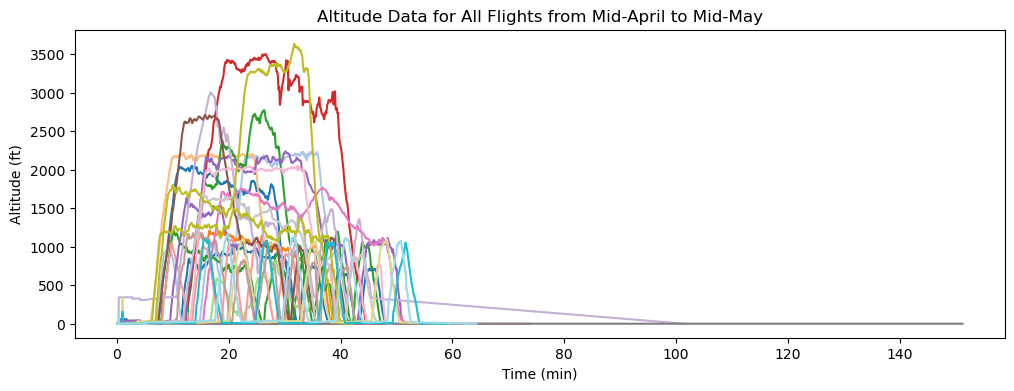

CPU times: total: 62.5 ms
Wall time: 559 ms


In [62]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')


plt.show()

### Circuit-Filtered Altitude Data 

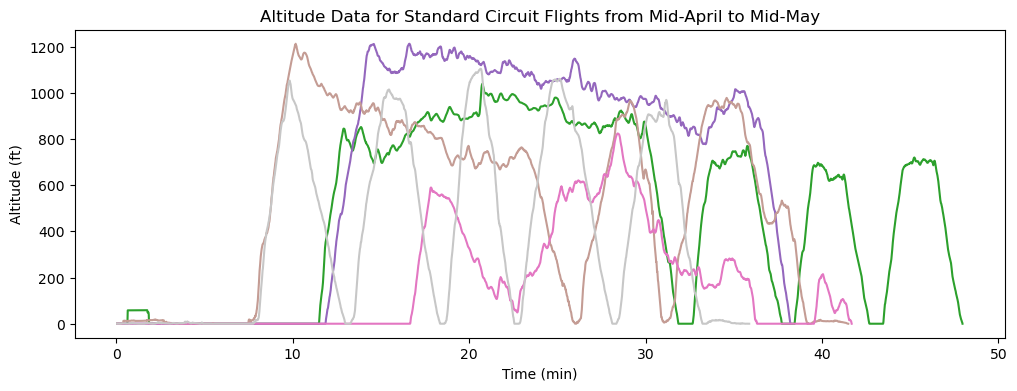

CPU times: total: 31.2 ms
Wall time: 389 ms


In [4]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

### Takeoff-Filtered Altitude Data

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Average Slope of Altitude per Time: 458.843 ft/min
Average Slope of Time per Altitude: 0.6 min/300 ft
Plotting...


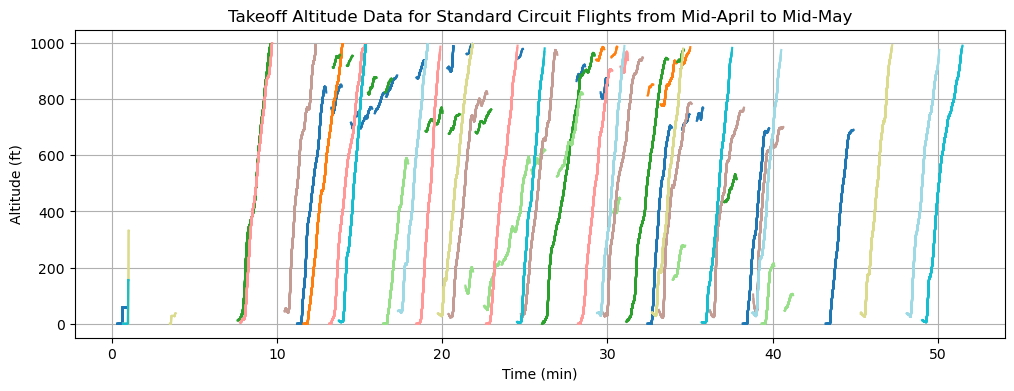

CPU times: total: 3.88 s
Wall time: 11.8 s


In [73]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_ft_per_min = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 100].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                # Stops indexing at 1000 when end index is greater than 1000
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # Finds average slope
                diff_alt_data = np.diff(alt_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_ft_per_min = diff_alt_data[valid_indices] / diff_time_data[valid_indices]
                slopes_ft_per_min.extend(slope_ft_per_min)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_ft_per_min))
print(f"Average Slope of Altitude per Time: {round(average_slope_soc_per_ft,3)} ft/min")
print(f"Average Slope of Time per Altitude: {round(1/average_slope_soc_per_ft,3)*300} min/300 ft")
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.419 min/300 ft
Plotting...


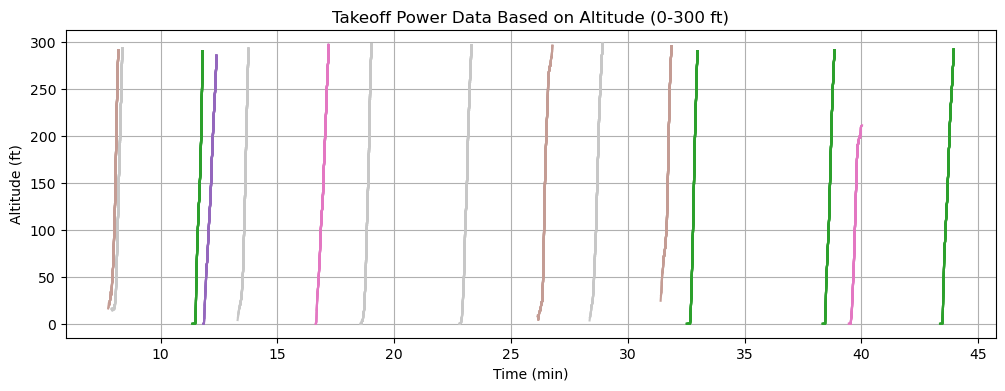

CPU times: total: 125 ms
Wall time: 1.66 s


In [6]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 400
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[0] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.528 min/300 ft
Plotting...


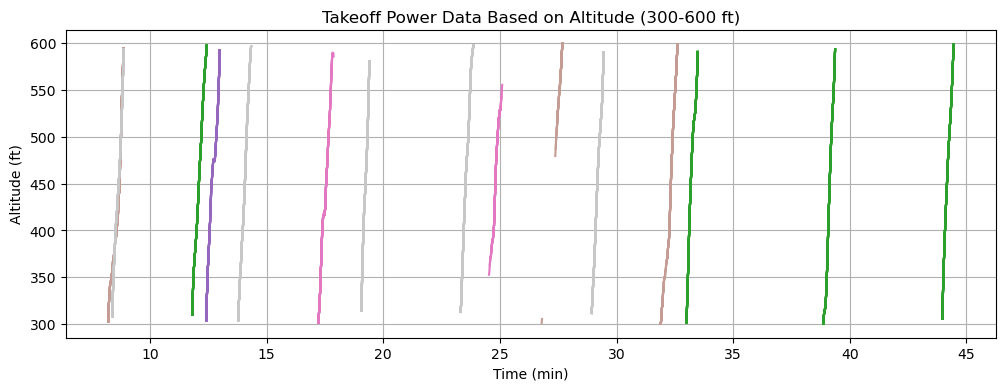

CPU times: total: 391 ms
Wall time: 2.11 s


In [7]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[1] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.572 min/300 ft
Plotting...


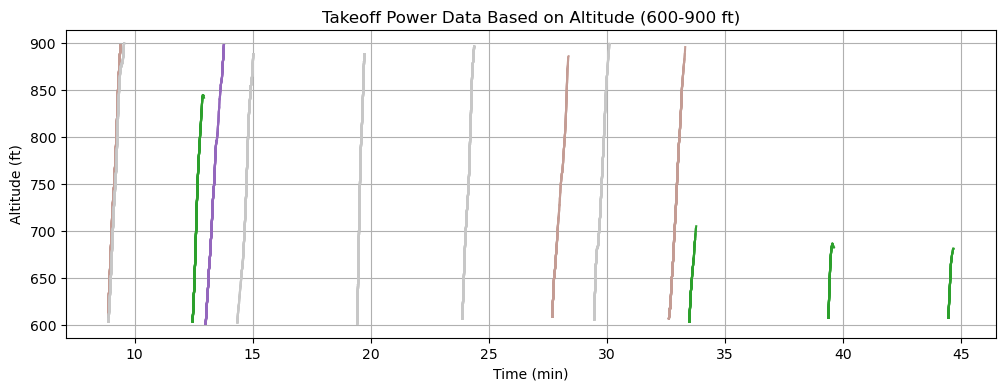

CPU times: total: 188 ms
Wall time: 1.7 s


In [8]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[2] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Takeoff Power Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


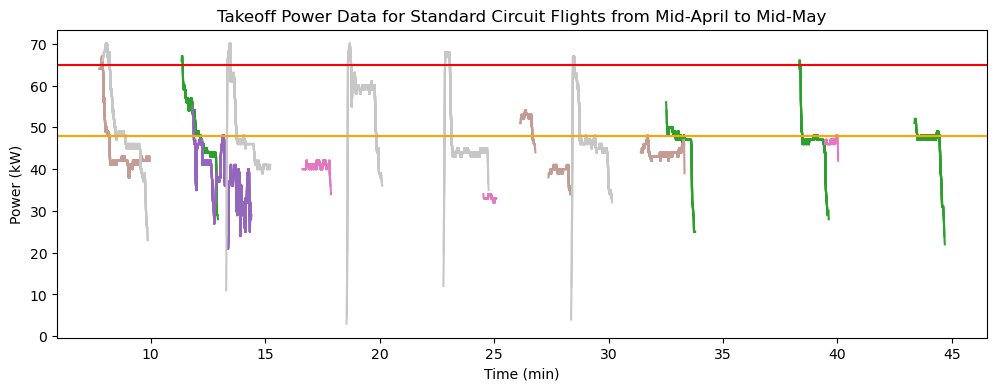

CPU times: total: 922 ms
Wall time: 2.78 s


In [9]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1400:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


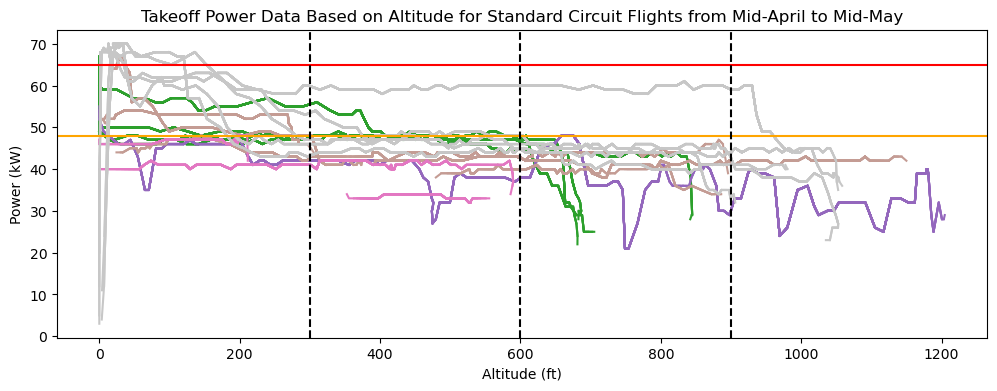

CPU times: total: 391 ms
Wall time: 2.7 s


In [10]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 50.607 kW
Plotting...


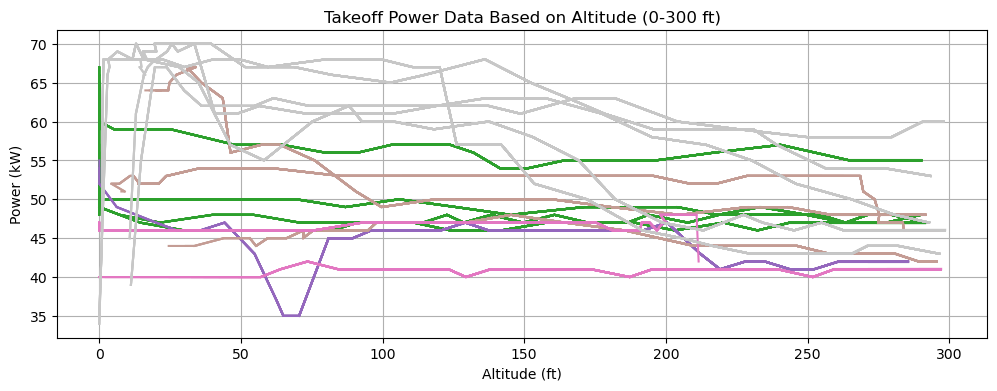

CPU times: total: 766 ms
Wall time: 2.38 s


In [11]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[0] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 45.925 kW
Plotting...


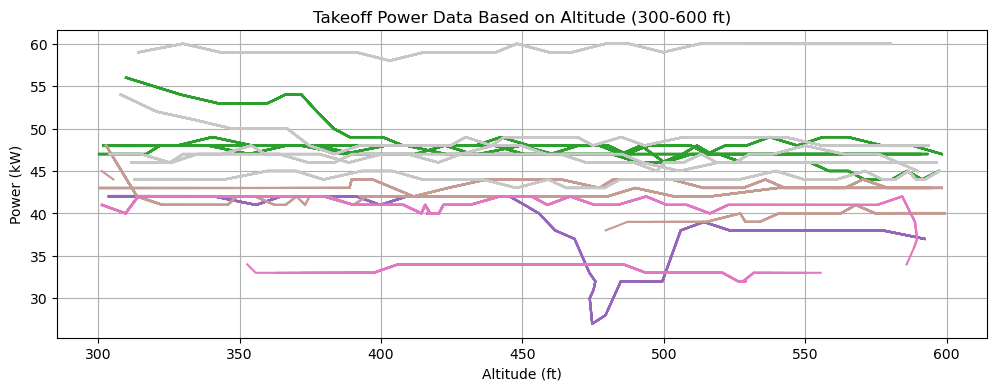

CPU times: total: 688 ms
Wall time: 2.46 s


In [12]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[1] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 43.884 kW
Plotting...


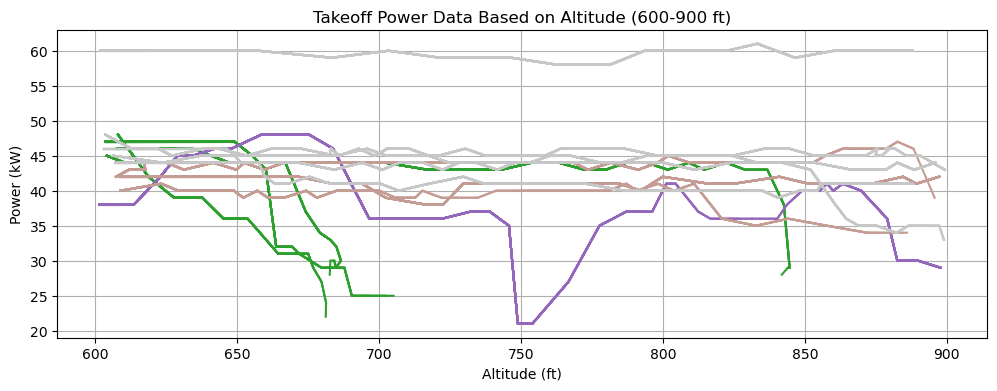

CPU times: total: 219 ms
Wall time: 1.63 s


In [13]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[2] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()



#### Power Seperated by OAT

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Power (OAT > 20°): 51.484 kW
Average Power (17.5°-20°): 52.586 kW
Average Power (15°-17.5°): 43.065 kW
Average Power (OAT < 15°): 49.667 kW
Plotting...


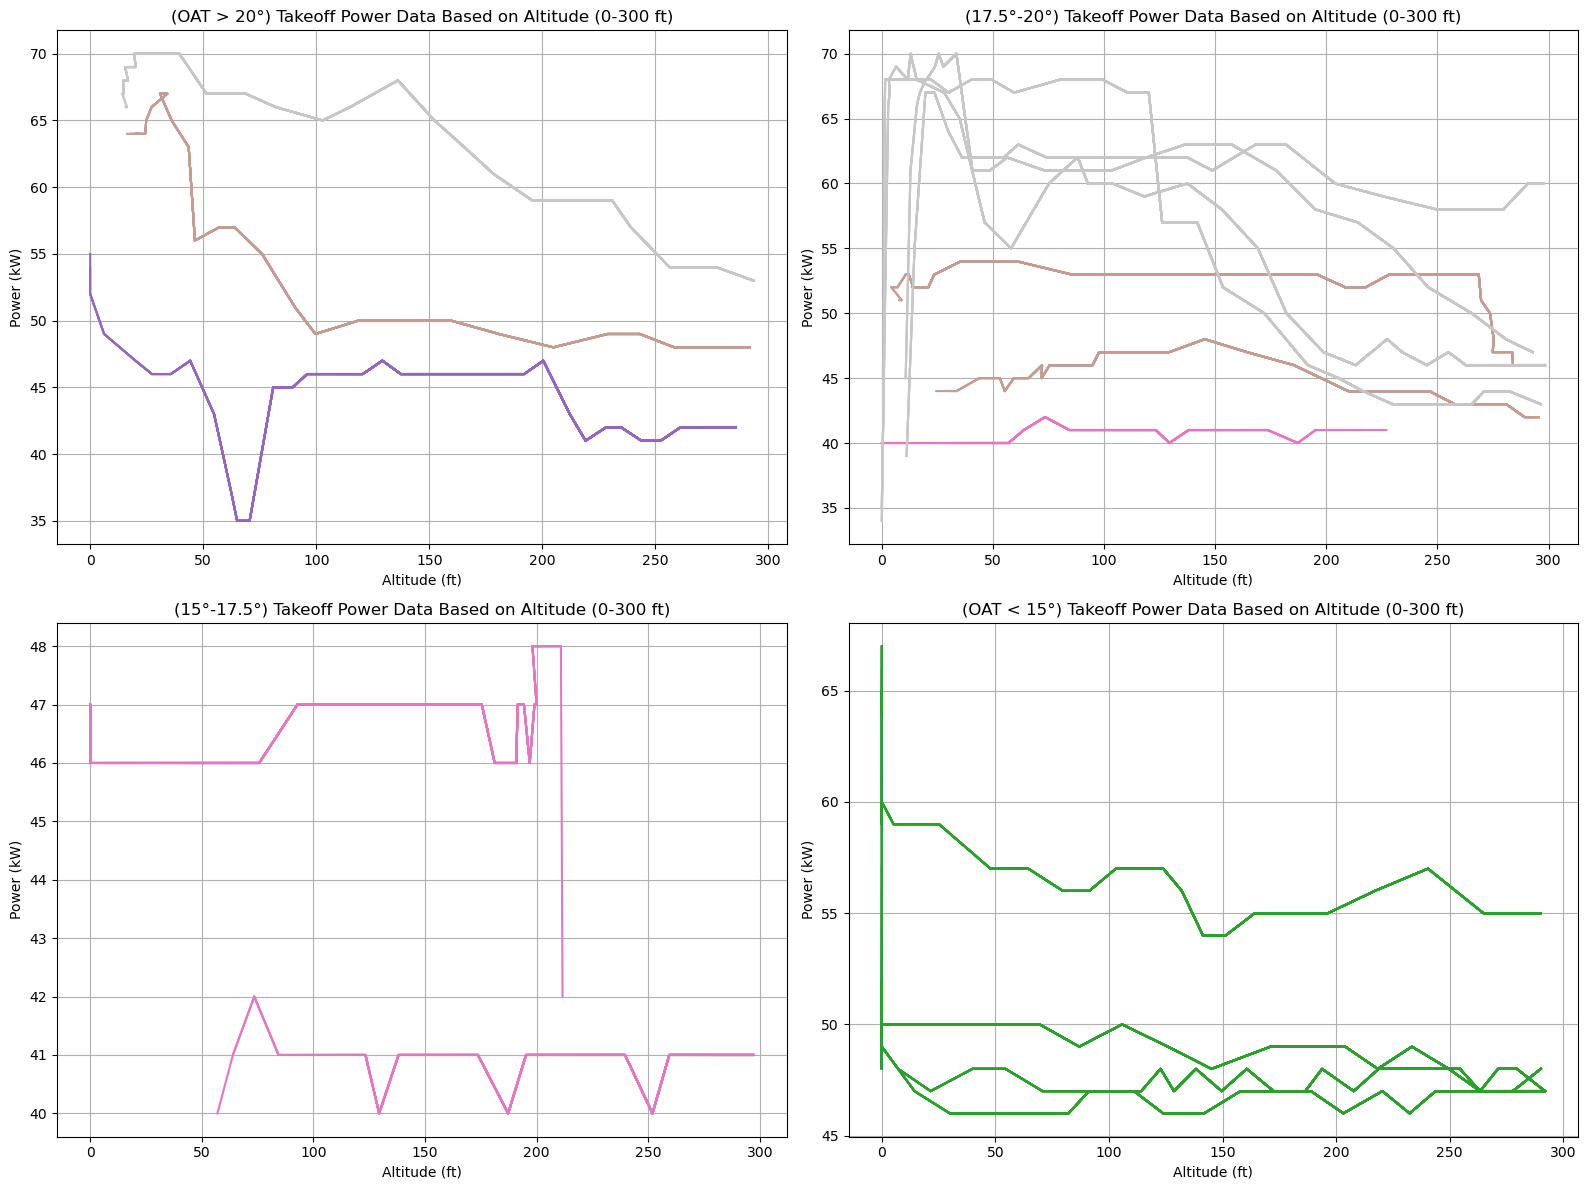

CPU times: total: 922 ms
Wall time: 4.06 s


In [14]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']

slopes_soc_per_ft = []
power_list_1 = []
power_list_2 = []
power_list_3 = []
power_list_4 = []

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = axes
powers = [0, 0, 0, 0]

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index

        if not high_slope_indices.empty:
            # Plots the data in between data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)

                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1

                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue

                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_oat = df_power["oat"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]

                mean_oat = np.mean(filtered_oat)
                if mean_oat > 20:
                    ax1.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_1.append(filtered_pwr.mean())
                elif 17.5 <= mean_oat <= 20:
                    ax2.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_2.append(filtered_pwr.mean())
                elif 15 <= mean_oat < 17.5:
                    ax3.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_3.append(filtered_pwr.mean())
                elif mean_oat < 15:
                    ax4.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_4.append(filtered_pwr.mean())

print('')
average_power_1 = round((abs(np.mean(power_list_1))), 3)
average_power_2 = round((abs(np.mean(power_list_2))), 3)
average_power_3 = round((abs(np.mean(power_list_3))), 3)
average_power_4 = round((abs(np.mean(power_list_4))), 3)
powers[0] = average_power_1
powers[1] = average_power_2
powers[2] = average_power_3
powers[3] = average_power_4

print(f"Average Power (OAT > 20°): {average_power_1} kW")
print(f"Average Power (17.5°-20°): {average_power_2} kW")
print(f"Average Power (15°-17.5°): {average_power_3} kW")
print(f"Average Power (OAT < 15°): {average_power_4} kW")
print("Plotting...")

# Configure the subplots
ax1.set_xlabel('Altitude (ft)')
ax1.set_ylabel('Power (kW)')
ax1.set_title('(OAT > 20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax1.grid(True)

ax2.set_xlabel('Altitude (ft)')
ax2.set_ylabel('Power (kW)')
ax2.set_title('(17.5°-20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax2.grid(True)

ax3.set_xlabel('Altitude (ft)')
ax3.set_ylabel('Power (kW)')
ax3.set_title('(15°-17.5°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax3.grid(True)

ax4.set_xlabel('Altitude (ft)')
ax4.set_ylabel('Power (kW)')
ax4.set_title('(OAT < 15°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax4.grid(True)

plt.tight_layout()
plt.show()

### Takeoff SoC Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


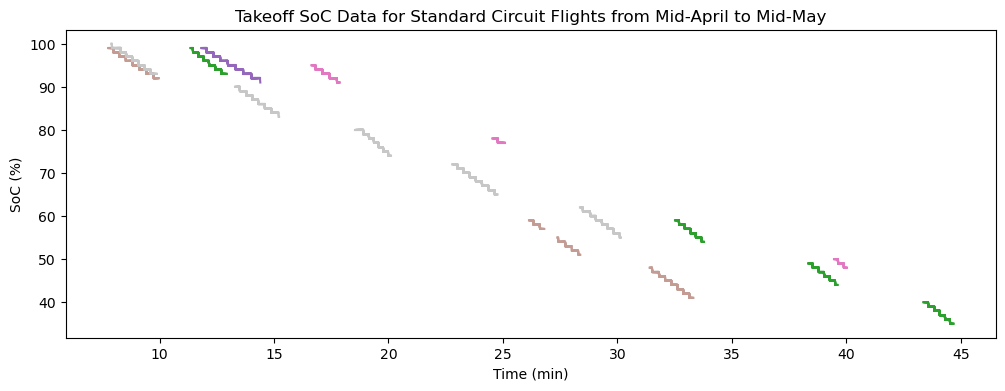

CPU times: total: 406 ms
Wall time: 2.51 s


In [15]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 11.277%/1000 ft
Plotting...


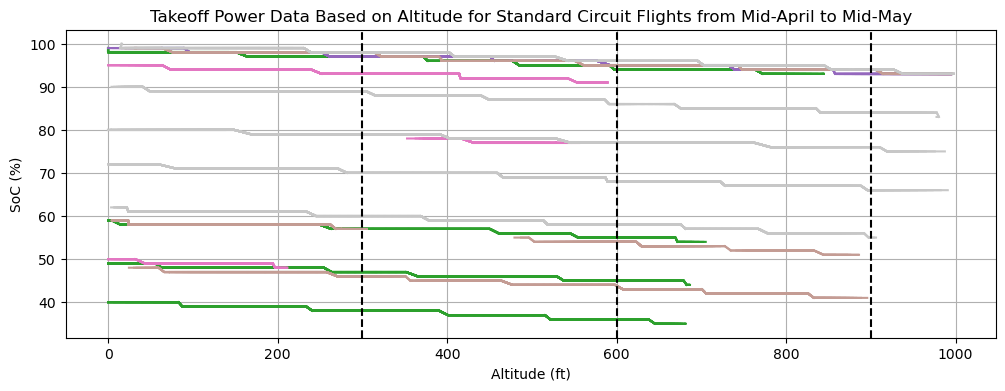

CPU times: total: 750 ms
Wall time: 2.66 s


In [16]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                time_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_time_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*1000
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/1000 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 1.619%/300 ft
Plotting...


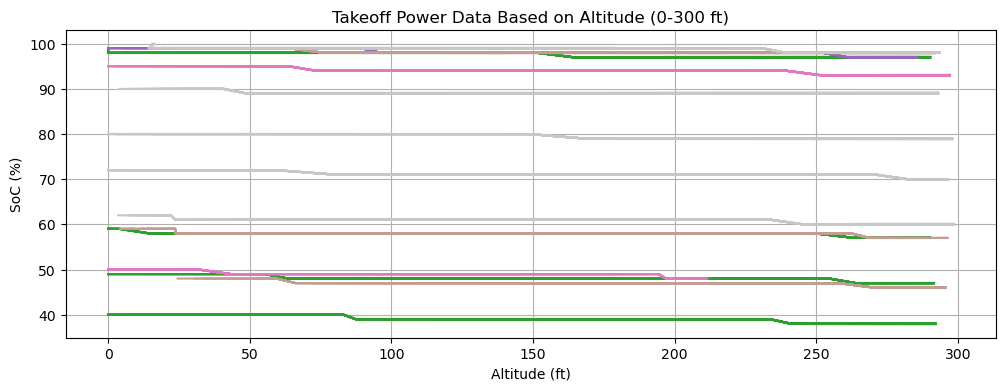

CPU times: total: 188 ms
Wall time: 1.82 s


In [17]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
                
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(alt_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))
                
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300 
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 2.411%/300 ft
Plotting...


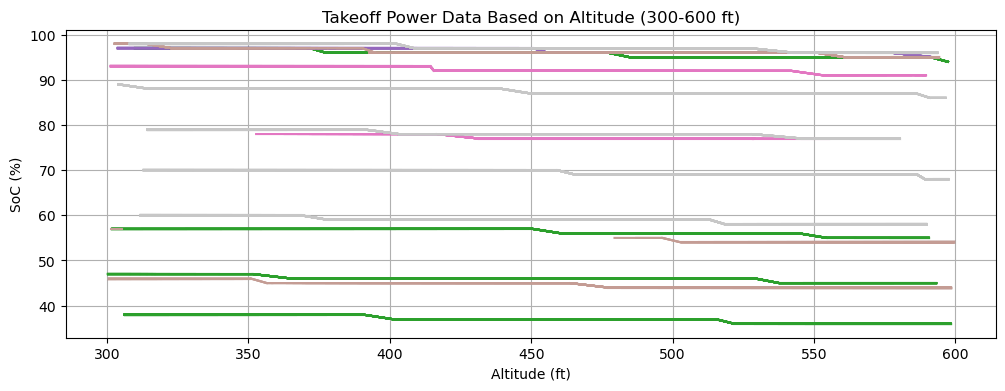

CPU times: total: 391 ms
Wall time: 2.14 s


In [18]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(soc_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 1.789%/300 ft
Plotting...


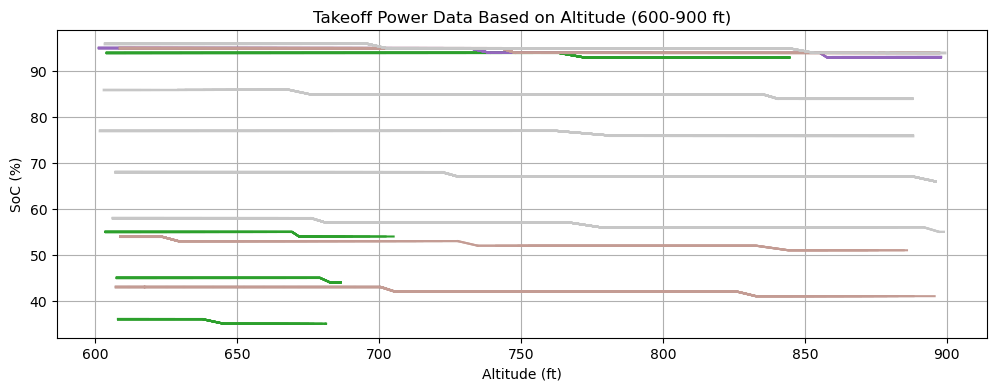

CPU times: total: 312 ms
Wall time: 1.91 s


In [19]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Average Total Energy Consumption

In [20]:
time_list = np.array(time_sum)
pwr_list = np.array(power_sum)
kWh_list = time_list*pwr_list/60
total_kWh = round((np.sum(kWh_list)),3)
print(f"Time per 300 ft:{time_list} min")
print(f"Average Power per 300 ft:{pwr_list} kW")
print(f"Divided Energy: {np.round(kWh_list,3)} kWh")
print(f"Total Energy: {total_kWh} kWh")
print(f"dSoC (At 75% SoH): {round((total_kWh/(24.8*0.75))*100,3)}%")

Time per 300 ft:[0.419 0.528 0.572] min
Average Power per 300 ft:[50.607 45.925 43.884] kW
Divided Energy: [0.353 0.404 0.418] kWh
Total Energy: 1.176 kWh
dSoC (At 75% SoH): 6.323%


## Current Code

#### Slope and Correlation Method

In [124]:
def calculate_slope_and_correlation(group, nrg = True):
    if len(group) < 2:
        return pd.Series({'Slope Linear': np.nan, 'R Linear': np.nan, 
                          'Slope Exponential': np.nan, 'R Exponential': np.nan})
    
    if nrg:
        x = group['Avg Power']
        y = group['Time']*group['Avg Power']/60
    else:
        x = group['Avg Power']
        y = group['Time']
    
    # Linear fit
    slope_linear = np.polyfit(x, y, 1)[0]
    correlation_matrix_linear = np.corrcoef(x, y)
    correlation_coefficient_linear = correlation_matrix_linear[0, 1]
    
    # Exponential fit (using logarithm of y)
    y_log = np.log(y)
    slope_exp = np.polyfit(x, y_log, 1)[0]
    correlation_matrix_exp = np.corrcoef(x, y_log)
    correlation_coefficient_exp = correlation_matrix_exp[0, 1]
    
    return pd.Series({'Slope Linear': slope_linear, 'R Linear': correlation_coefficient_linear,
                      'Slope Exponential': slope_exp, 'R Exponential': correlation_coefficient_exp})

### Filtering Out Standing and Rolling Takeoffs (25-175 ft)

#### Standing Takeoff

##### Altitude

Processing file data/vancouver/flight/csv-25231-5980_may09_0527pm_dc [12%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


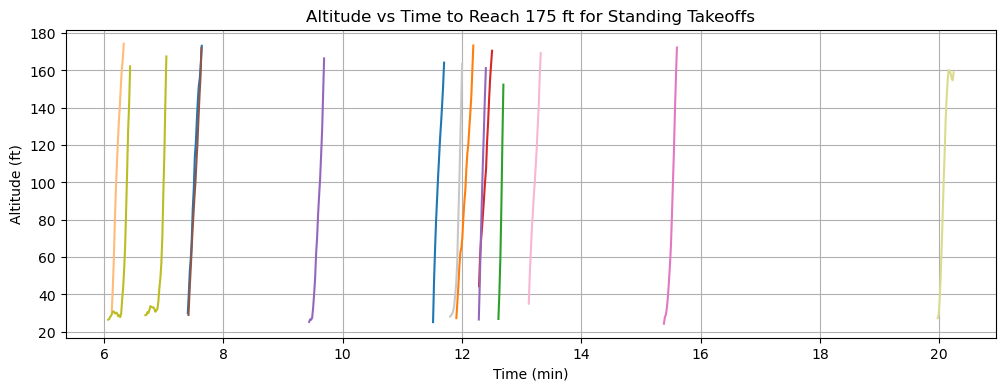

CPU times: total: 688 ms
Wall time: 2.31 s


In [79]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude vs Time to Reach 175 ft for Standing Takeoffs')
plt.grid(True)
plt.show()


##### Average Time

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


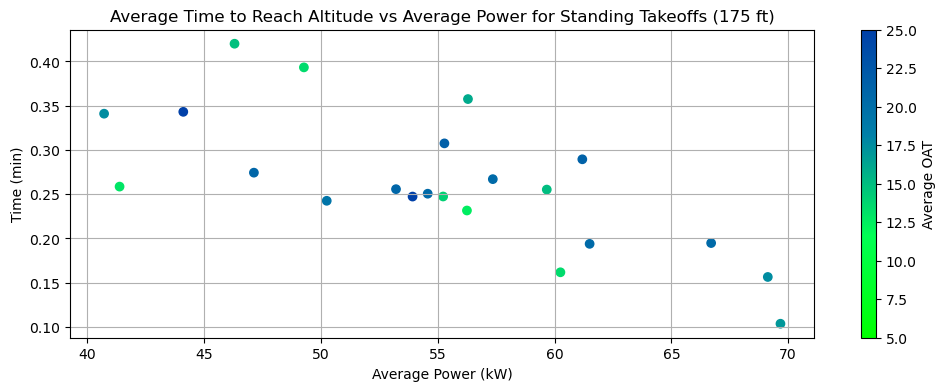

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15     -0.008686 -0.610093          -0.033303      -0.658480
2   15-20     -0.007146 -0.799593          -0.034429      -0.804369
3   20-25     -0.003891 -0.568383          -0.017009      -0.597553
CPU times: total: 578 ms
Wall time: 2.24 s


<timed exec>:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [80]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


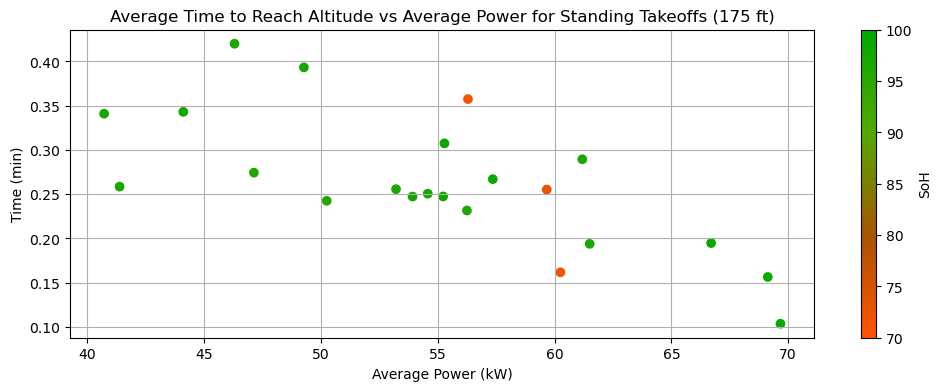

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80     -0.042904 -0.935679          -0.165956      -0.890167
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.006677 -0.752583          -0.029195      -0.779007
CPU times: total: 1.36 s
Wall time: 2.25 s


<timed exec>:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [81]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    continue
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


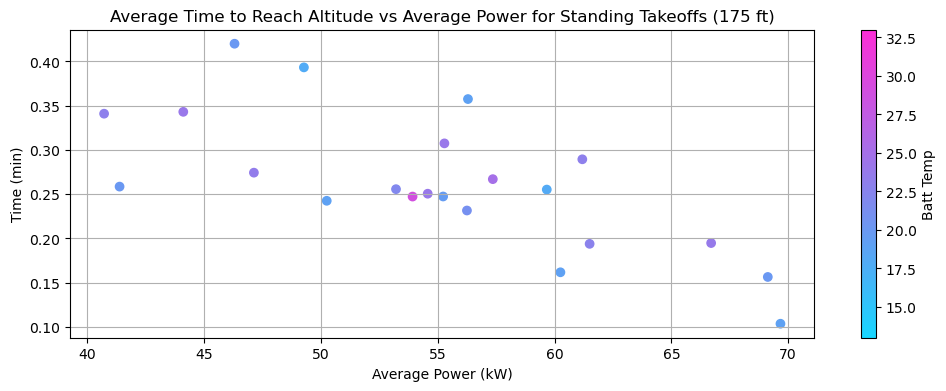

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18           NaN       NaN                NaN            NaN
1     18-23     -0.007238 -0.703668          -0.033915      -0.757285
2     23-28     -0.004440 -0.799847          -0.016473      -0.790081
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.47 s
Wall time: 2.53 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [82]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 1.71:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation,False).reset_index()

print(slopes_and_corr)

In [83]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope, False)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.006726
R Linear            -0.712073
Slope Exponential   -0.029293
R Exponential       -0.738227
dtype: float64



##### Average Energy

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


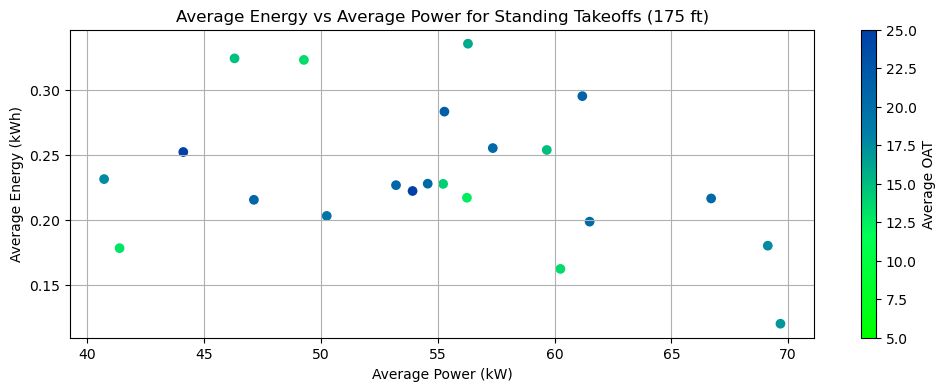

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15     -0.003366 -0.338487          -0.013436      -0.325135
2   15-20     -0.002906 -0.446507          -0.016207      -0.522511
3   20-25      0.000278  0.048476           0.000668       0.028649
CPU times: total: 1.27 s
Wall time: 2.2 s


<timed exec>:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [84]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


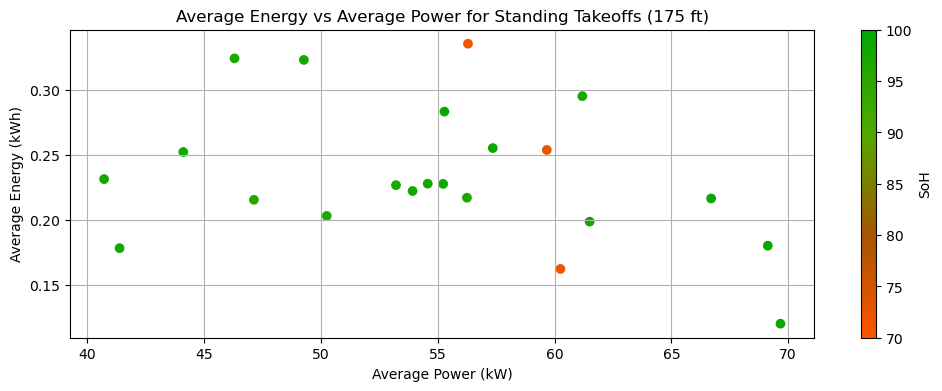

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80     -0.037023 -0.913435          -0.148759      -0.868215
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.002130 -0.366246          -0.010789      -0.405501
CPU times: total: 1.28 s
Wall time: 2.2 s


<timed exec>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [85]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()


bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


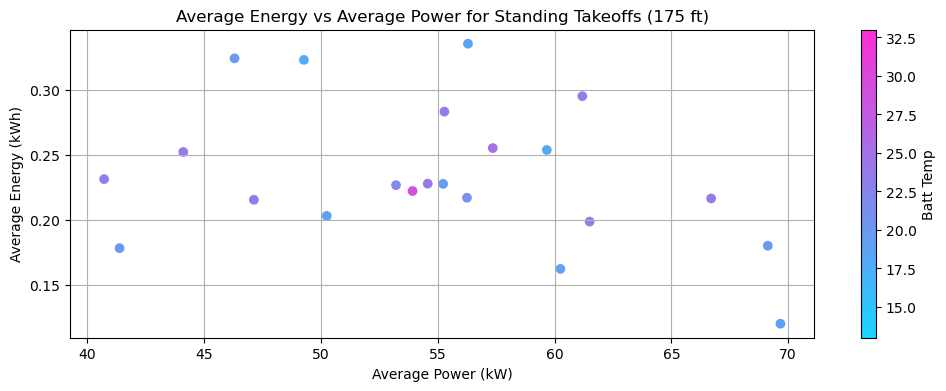

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18           NaN       NaN                NaN            NaN
1     18-23     -0.003149 -0.421540          -0.015832      -0.464958
2     23-28      0.000725  0.213849           0.002600       0.193341
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.25 s
Wall time: 2.33 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [86]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 1.71:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

In [87]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.002129
R Linear            -0.321620
Slope Exponential   -0.010827
R Exponential       -0.365655
dtype: float64



#### Rolling Takeoff

##### Altitude

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


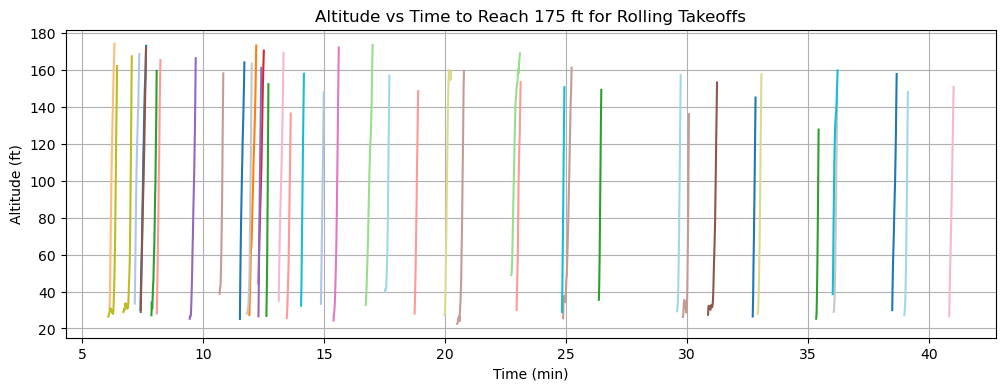

CPU times: total: 828 ms
Wall time: 1.93 s


In [133]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 0
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: 
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
            
print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude vs Time to Reach 175 ft for Rolling Takeoffs')
plt.grid(True)
plt.show()

##### Average Time

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


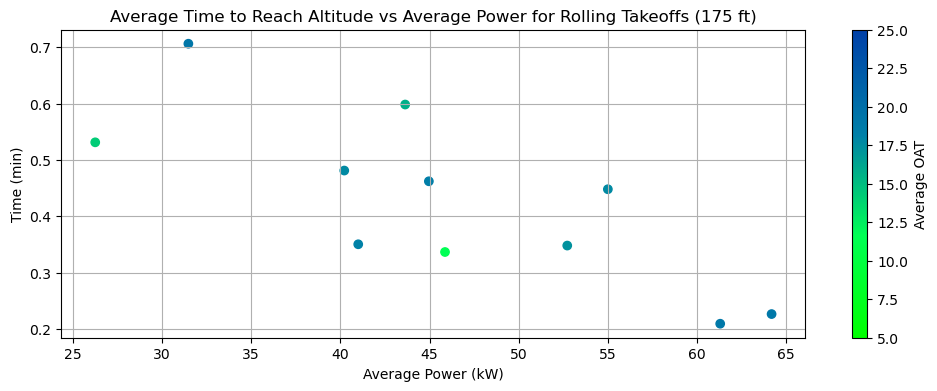

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15     -0.009930 -1.000000          -0.023282      -1.000000
2   15-20     -0.012739 -0.839546          -0.032367      -0.849911
3   20-25           NaN       NaN                NaN            NaN
CPU times: total: 984 ms
Wall time: 3.06 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [89]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


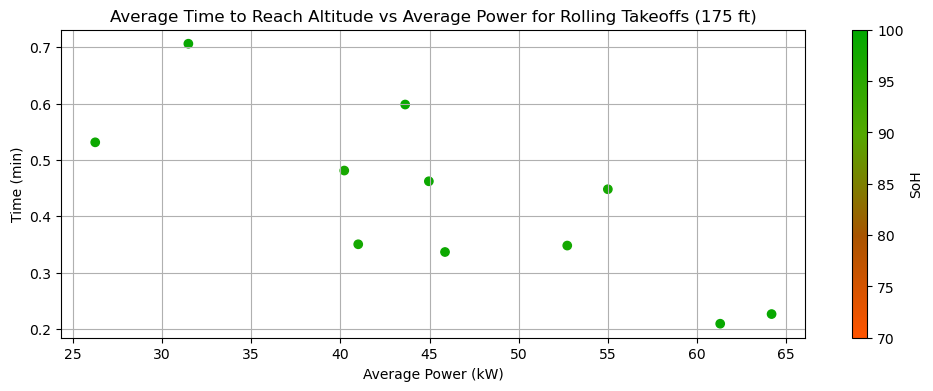

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.010171 -0.779582          -0.026195      -0.802537
CPU times: total: 1.12 s
Wall time: 2.41 s


<timed exec>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [90]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                        
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    continue
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True        
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


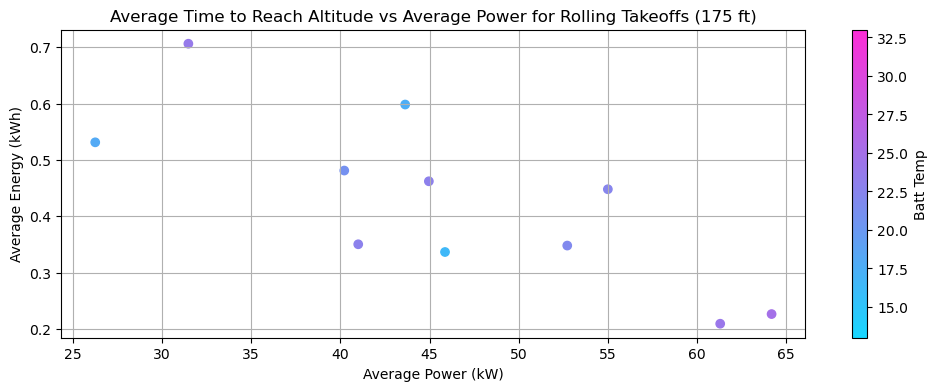

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18     -0.117270 -1.000000          -0.257761      -1.000000
1     18-23     -0.004145 -0.582319          -0.009137      -0.543106
2     23-28     -0.015492 -0.993953          -0.037254      -0.990557
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.67 s
Wall time: 2.44 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [91]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 1.71:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation,False).reset_index()

print(slopes_and_corr)

In [92]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope, False)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.010171
R Linear            -0.779582
Slope Exponential   -0.026195
R Exponential       -0.802537
dtype: float64



##### Average Energy

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


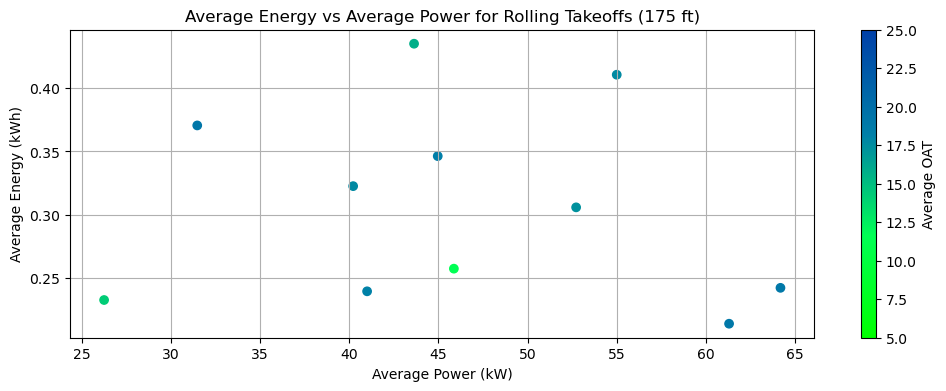

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15      0.001264  1.000000           0.005167       1.000000
2   15-20     -0.003241 -0.444946          -0.011220      -0.478457
3   20-25           NaN       NaN                NaN            NaN
CPU times: total: 1.52 s
Wall time: 2.3 s


<timed exec>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [93]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
            
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']

df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


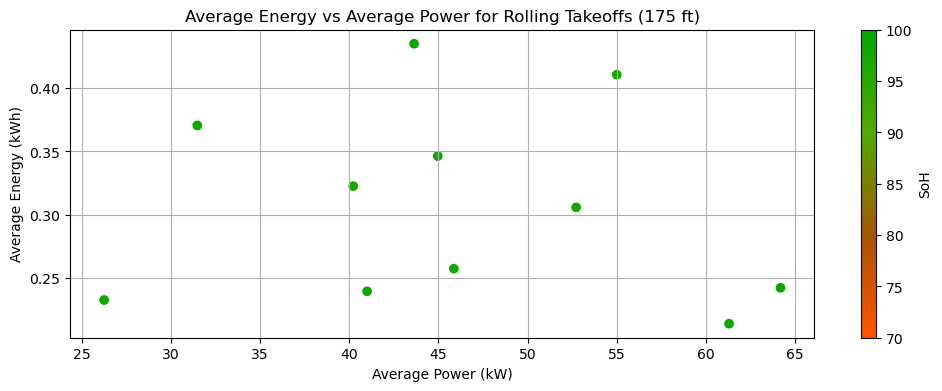

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.000901 -0.137243          -0.003288      -0.155294
CPU times: total: 859 ms
Wall time: 2.39 s


<timed exec>:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [94]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


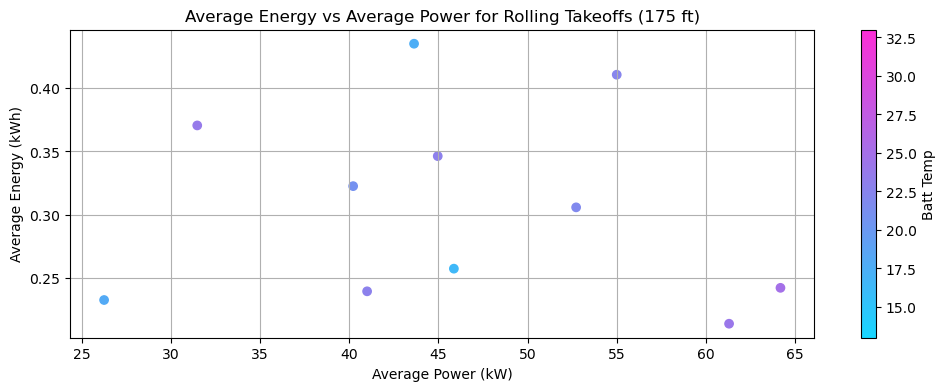

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18     -0.079673 -1.000000          -0.235410      -1.000000
1     18-23      0.004953  0.760729           0.016357       0.771265
2     23-28     -0.004472 -0.968837          -0.015238      -0.956083
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.7 s
Wall time: 2.43 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [95]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 1.71:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

In [96]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.000901
R Linear            -0.137243
Slope Exponential   -0.003288
R Exponential       -0.155294
dtype: float64



### Filtering Out Standing and Rolling Takeoffs (25-900 ft)

#### Standing Takeoff

##### Altitude

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


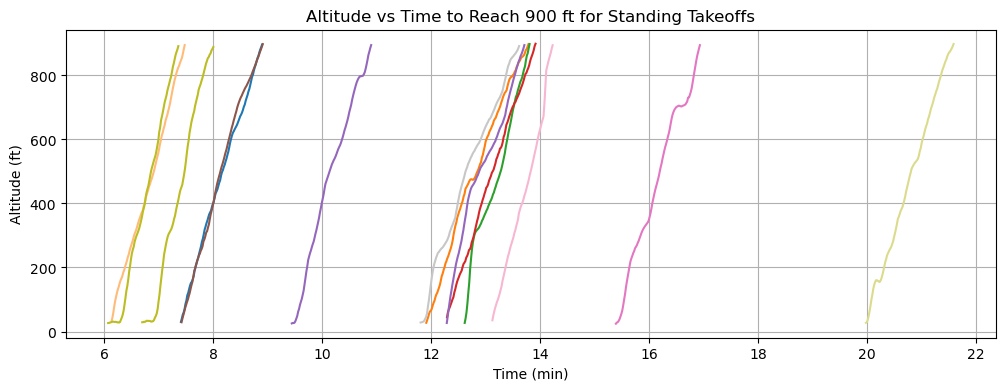

CPU times: total: 1.67 s
Wall time: 2.81 s


In [97]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude vs Time to Reach 900 ft for Standing Takeoffs')
plt.grid(True)
plt.show()


##### Average Time

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


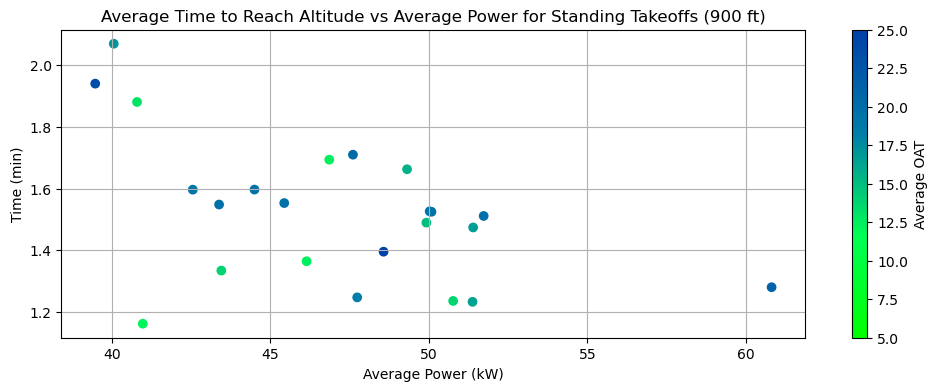

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15     -0.012086 -0.188548          -0.006202      -0.144850
2   15-20     -0.037754 -0.669303          -0.023187      -0.654474
3   20-25     -0.031506 -0.994417          -0.019871      -0.994681
CPU times: total: 1.11 s
Wall time: 3.24 s


<timed exec>:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [98]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


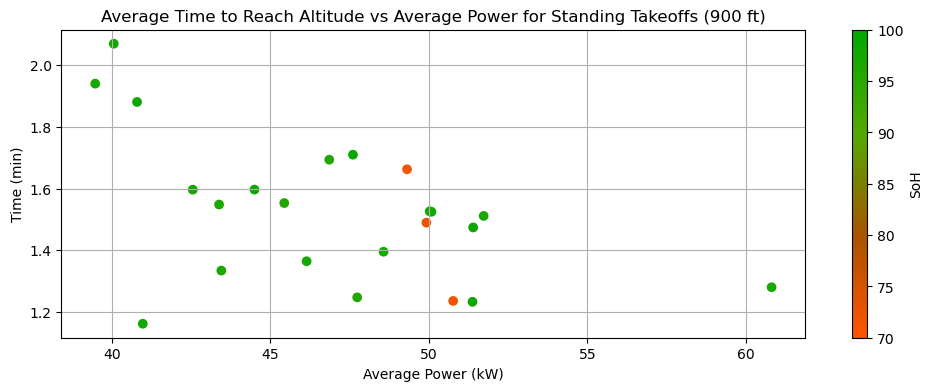

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80     -0.293815 -0.999883          -0.204968      -0.998488
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.023625 -0.505688          -0.014322      -0.478932
CPU times: total: 2 s
Wall time: 2.95 s


<timed exec>:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [99]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    continue
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


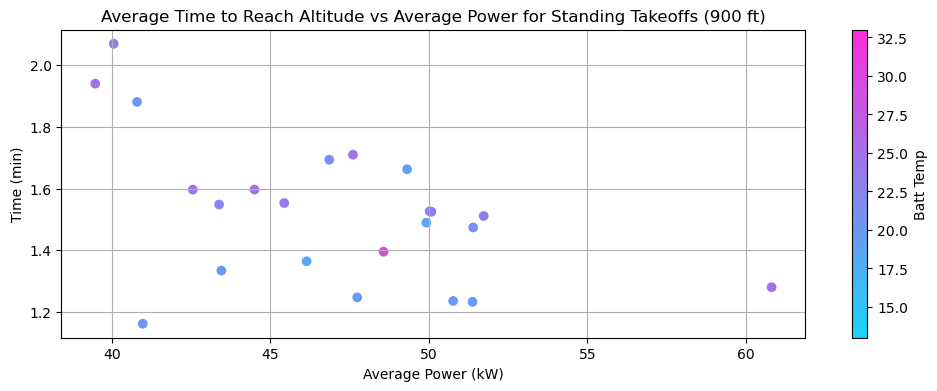

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18           NaN       NaN                NaN            NaN
1     18-23      0.014345  0.330196           0.014508       0.359660
2     23-28      0.002110  0.169168           0.001832       0.183737
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.81 s
Wall time: 3.73 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [100]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

In [101]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope, False)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.024003
R Linear            -0.505547
Slope Exponential   -0.014608
R Exponential       -0.477447
dtype: float64



##### Average Energy

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


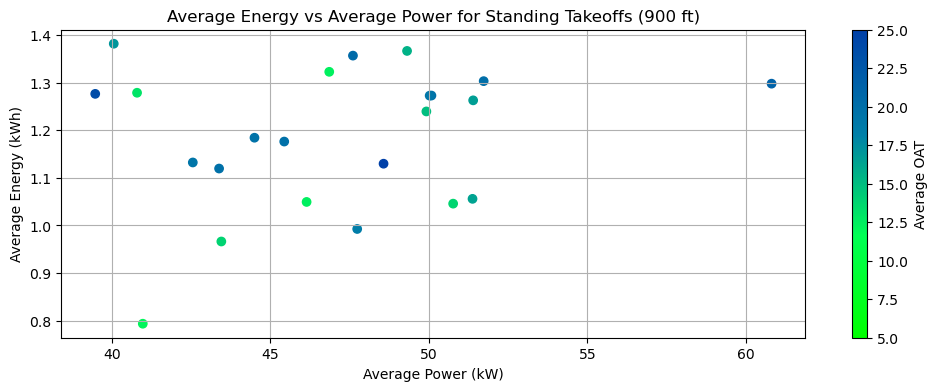

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15      0.014740  0.309751           0.015793       0.348715
2   15-20     -0.001764 -0.056118          -0.001474      -0.055608
3   20-25      0.000412  0.107229           0.000334       0.114391
CPU times: total: 1.69 s
Wall time: 3.01 s


<timed exec>:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [102]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


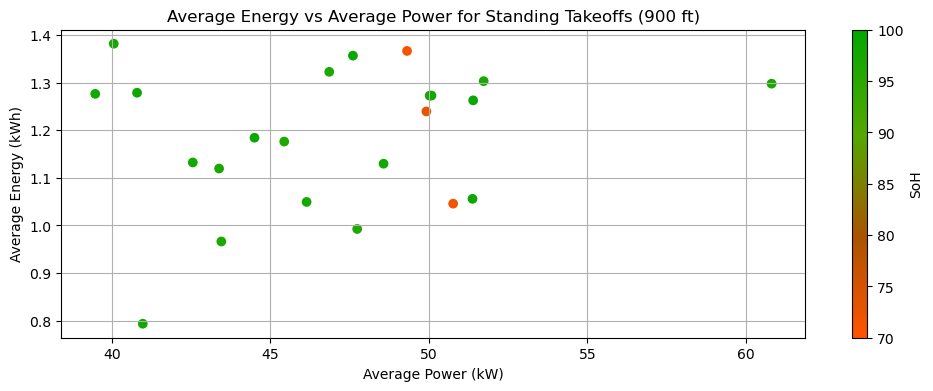

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80     -0.221054 -0.999665          -0.184989      -0.998117
1   80-90           NaN       NaN                NaN            NaN
2  90-100      0.006643  0.226464           0.006446       0.240470
CPU times: total: 1.83 s
Wall time: 3 s


<timed exec>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [103]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()


bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


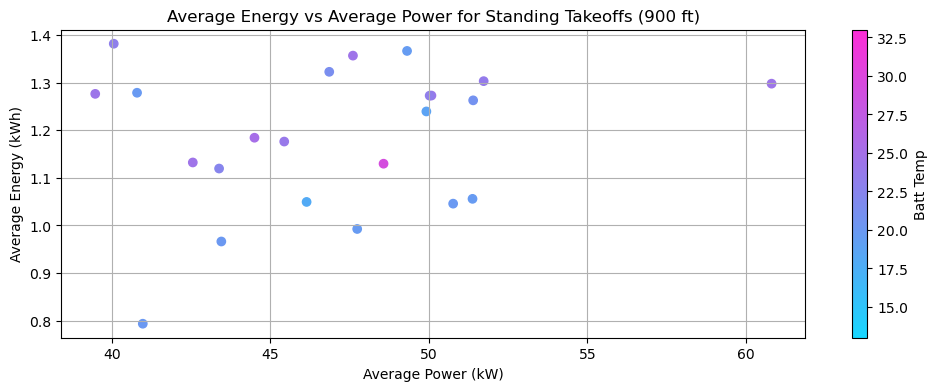

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18           NaN       NaN                NaN            NaN
1     18-23      0.014345  0.330196           0.014508       0.359660
2     23-28      0.002110  0.169168           0.001832       0.183737
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 2 s
Wall time: 3.99 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [104]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

In [105]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear         0.006414
R Linear             0.212005
Slope Exponential    0.006245
R Exponential        0.227814
dtype: float64



#### Rolling Takeoff

##### Altitude

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


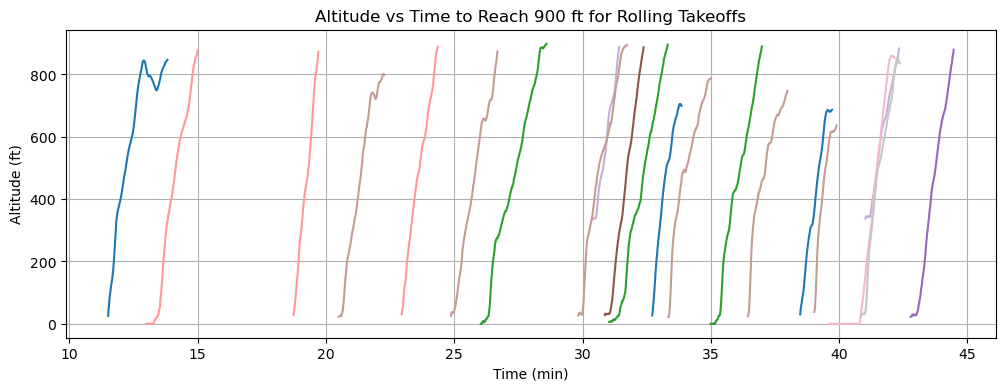

CPU times: total: 781 ms
Wall time: 3.75 s


In [127]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: 
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
            
print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude vs Time to Reach 900 ft for Rolling Takeoffs')
plt.grid(True)
plt.show()

##### Average Time

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


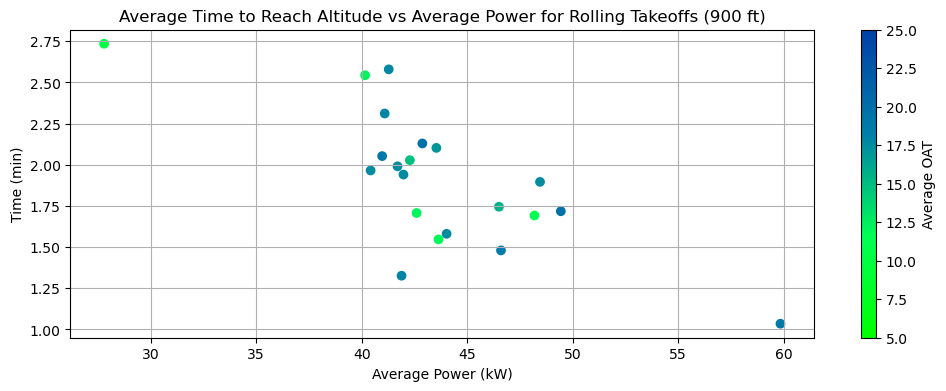

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15     -0.058692 -0.822019          -0.027157      -0.798435
2   15-20     -0.052674 -0.681297          -0.033093      -0.726666
3   20-25           NaN       NaN                NaN            NaN
CPU times: total: 875 ms
Wall time: 3.95 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [128]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        initial_range = True
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                
            
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()


bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']


df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)



slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


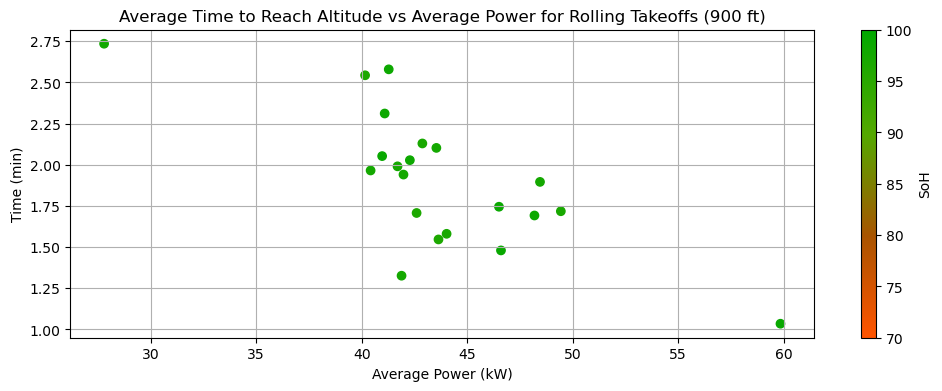

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.054277  -0.74646          -0.030073      -0.752666
CPU times: total: 953 ms
Wall time: 2.76 s


<timed exec>:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [129]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 1 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                        
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    continue
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 1 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True        
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation, False).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


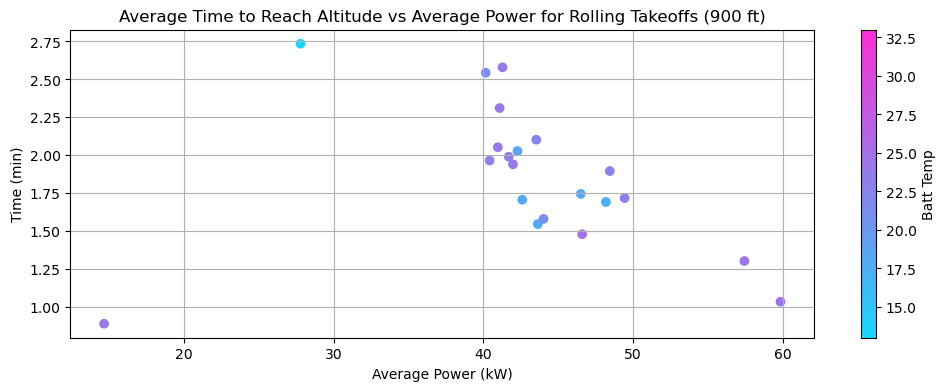

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18     -0.057346 -0.947184          -0.026780      -0.935474
1     18-23     -0.063336 -0.544508          -0.029411      -0.512620
2     23-28      0.000368  0.008200           0.002443       0.085408
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.97 s
Wall time: 3.77 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [109]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"], marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Time (min)')
plt.title('Average Time to Reach Altitude vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation,False).reset_index()

print(slopes_and_corr)

In [110]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope, False)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear        -0.009826
R Linear            -0.190916
Slope Exponential   -0.002704
R Exponential       -0.088664
dtype: float64



##### Average Energy

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


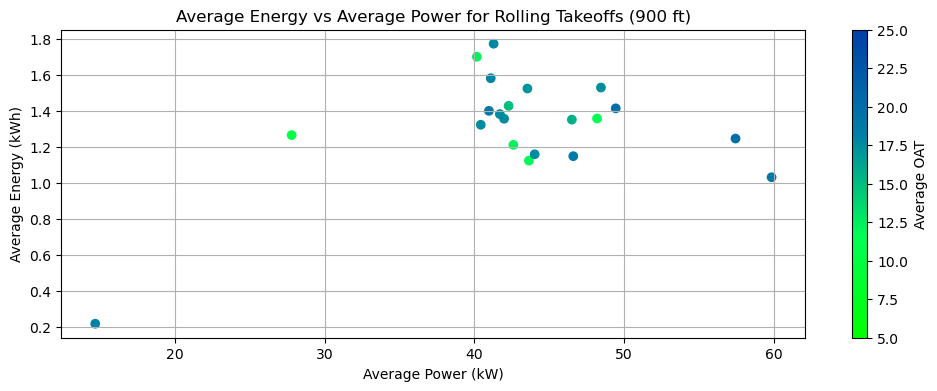

  OAT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0    5-10           NaN       NaN                NaN            NaN
1   10-15      0.000643  0.021772           0.000417       0.019800
2   15-20      0.018022  0.512201           0.033545       0.680978
3   20-25           NaN       NaN                NaN            NaN
CPU times: total: 1.75 s
Wall time: 3.83 s


<timed exec>:152: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [111]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
            
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average OAT"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average OAT', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [5, 10, 15, 20, 25]
labels = ['5-10', '10-15', '15-20', '20-25']

df_slope['OAT Bin'] = pd.cut(df_slope['Average OAT'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('OAT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


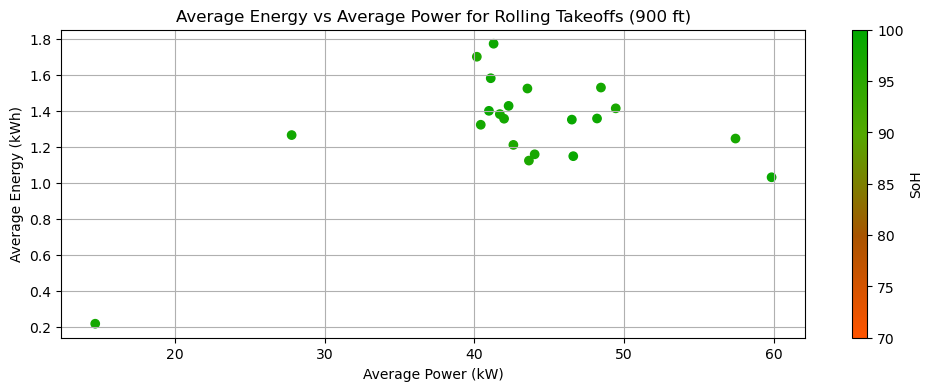

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100      0.014715  0.431512           0.027222       0.591981
CPU times: total: 2.09 s
Wall time: 4 s


<timed exec>:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [112]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


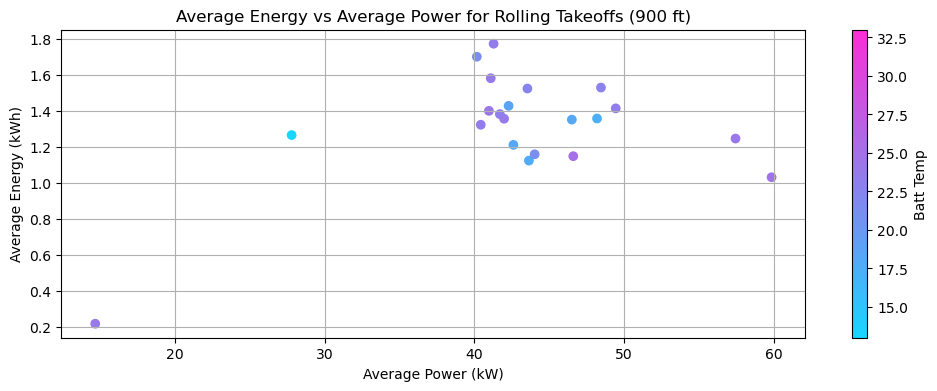

  BattT Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0     13-18      0.001010  0.091735           0.000594       0.066606
1     18-23     -0.011767 -0.170548          -0.006865      -0.139433
2     23-28      0.017452  0.511593           0.033120       0.680243
3     28-33           NaN       NaN                NaN            NaN
CPU times: total: 1.59 s
Wall time: 3.79 s


<timed exec>:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [113]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0.09, 0.84, 1.0), (0.4, 0.61, 0.95), (0.7, 0.4, 0.9),(0.99, 0.18, 0.84)]

nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=13, vmax=33)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Average Batt Temp"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Batt Temp', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [13, 18, 23, 28, 33]
labels = ['13-18', '18-23', '23-28', '28-33']

df_slope['BattT Bin'] = pd.cut(df_slope['Average Batt Temp'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('BattT Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

In [114]:
slopes_and_corrs = calculate_slope_and_correlation(df_slope)
print("General Slopes and Correlations:")
print(slopes_and_corrs)
print('')

General Slopes and Correlations:
Slope Linear         0.014715
R Linear             0.431512
Slope Exponential    0.027222
R Exponential        0.591981
dtype: float64



### Influence of initial power 

#### Standing

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


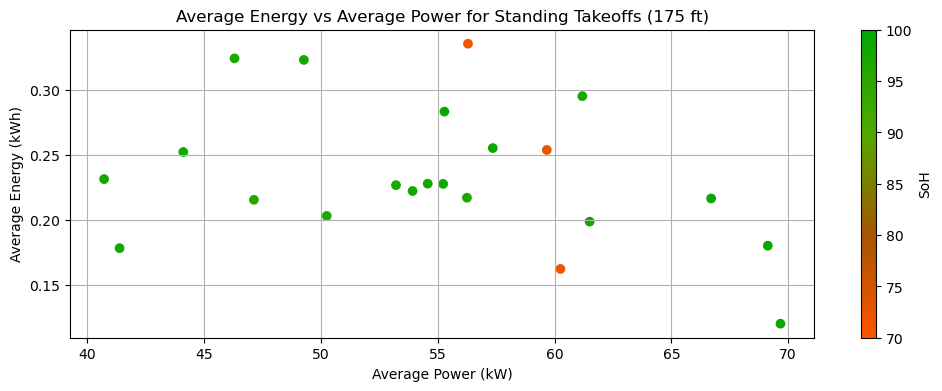

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80     -0.037023 -0.913435          -0.148759      -0.868215
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.002130 -0.366246          -0.010789      -0.405501
{56.25: (1, 'data/vancouver/flight/csv-25030-5911_may02_0126am_dc'), 47.13333333333333: (1, 'data/vancouver/flight/csv-25168-5958_may09_1205am_dc'), 50.25: (1, 'data/vancouver/flight/csv-25231-5980_may09_0527pm_dc'), 44.111111111111114: (1, 'data/vancouver/flight/csv-25237-5983_may09_0837pm_dc'), 53.92307692307692: (1, 'data/vancouver/flight/csv-25245-5987_may09_1129pm_dc'), 69.66666666666667: (1, 'data/vancouver/flight/csv-25318-6014_may14_0518pm_dc'), 57.357142857142854: (1, 'data/vancouver/flight/csv-25322-6016_may13_1158pm_dc'), 40.72222222222222: (1, 'data/vancouver/flight/csv-25326-6018_may13_0839pm_dc'), 55.285714285714285: (1, 'data/vancouver/flight/csv-25340-6020_may14_0734pm_dc'), 66.7: (1, 'data/vancouver/fl

C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\788859595.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\788859595.py:156: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()


In [115]:
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the dictionary to store the value of each plotted energy point and the index of count_num to the subfolder name
energy_points_dict = {}

cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0]
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100

    count_num = 1

    if not high_slope_indices.empty:
        # Plots the data in between data sufficient slope

        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100

        for idx in high_slope_indices:

            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175

            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue

            if df_power["alt"][i][end_idx] < min_lim:
                continue

            if df_power["alt"][i][start_idx] > max_lim:
                continue

            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx

            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)

            if start_idx >= end_idx:
                continue

            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]

            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()

                    diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                    diff_time = full_time_data[end_index] - full_time_data[start_index]
                    time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count == count_num:  #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                        # Store the value and index in the dictionary
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        plotted = True
                        initial_range = True

            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index

                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False

            end_index = end_idx
            prev_mean = alt_mean

        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()

                    diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                    diff_time = full_time_data[end_index] - full_time_data[start_index]
                    time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8:  # Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                        # Store the value and index in the dictionary
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        initial_range = True

print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"] * df_slope["Avg Power"] / 60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

# Print the dictionary to verify its content
print(energy_points_dict)


Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


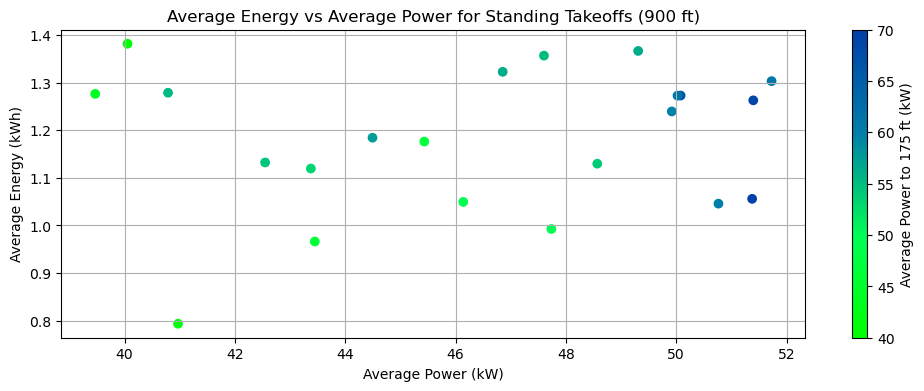

  Initial Power  Slope Linear  R Linear  Slope Exponential  R Exponential
0         40-50     -0.021039 -0.278030          -0.014963      -0.210273
1         50-60      0.006468  0.165783           0.004776       0.145357
2         60-70     -0.020832 -0.127692          -0.018583      -0.132381
CPU times: total: 2.2 s
Wall time: 3.84 s


<timed exec>:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [116]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0]  
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                plotted = True
                                initial_range = True
                                break
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                initial_range = True
                                break


                        
                        
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Initial Power"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average Power to 175 ft (kW)', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [40, 50, 60, 70]
labels = ['40-50', '50-60', '60-70']

df_slope['Initial Power'] = pd.cut(df_slope['Initial Power'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('Initial Power').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

#### Rolling

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...
{26.25: (1, 'data/vancouver/flight/csv-25318-6014_may14_0518pm_dc'), 44.96153846153846: (1, 'data/vancouver/flight/csv-25322-6016_may13_1158pm_dc'), 31.473684210526315: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 61.3: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 64.18181818181819: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 43.63333333333333: (1, 'data/vancouver/flight/csv-25425-6050_may15_0540pm_dc'), 40.21739130434783: (1, 'data/vancouver/flight/csv-26359-6366_jun11_1214am_dc'), 52.72222222222222: (1, 'data/vancouver/flight/csv-26583-6441_jun13_1233am_dc'), 55.0: (1, 'data/vancouver/flight/csv-26583-6441_jun13_1233am_dc'), 41.0: (1, 'data/vancouver/flight/csv-26583-6441_jun13_1233am_dc'), 45.86666666666667: (1, 'data/vancouver/flight/dcsv-24919-5873_apr24_1006pm_dc')}


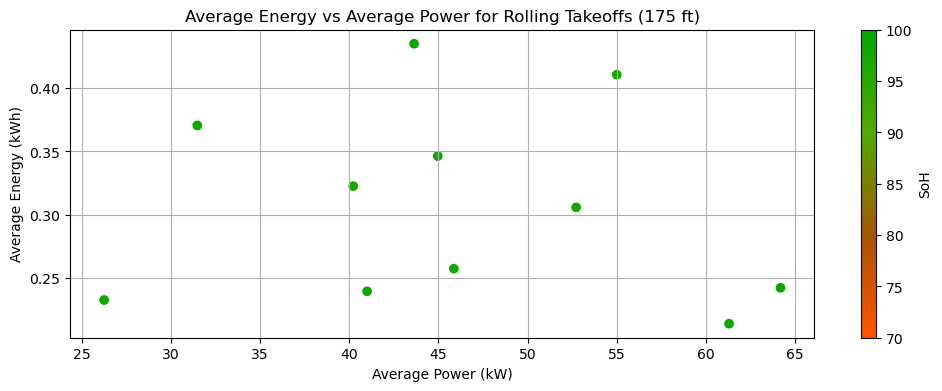

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.000901 -0.137243          -0.003288      -0.155294
{26.25: (1, 'data/vancouver/flight/csv-25318-6014_may14_0518pm_dc'), 44.96153846153846: (1, 'data/vancouver/flight/csv-25322-6016_may13_1158pm_dc'), 31.473684210526315: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 61.3: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 64.18181818181819: (1, 'data/vancouver/flight/csv-25344-6022_may14_0942pm_dc'), 43.63333333333333: (1, 'data/vancouver/flight/csv-25425-6050_may15_0540pm_dc'), 40.21739130434783: (1, 'data/vancouver/flight/csv-26359-6366_jun11_1214am_dc'), 52.72222222222222: (1, 'data/vancouver/flight/csv-26583-6441_jun13_1233am_dc'), 55.0: (1, 'data/vancouver/flight/csv-26583-6441_jun13_1233am_dc'), 41.0: (1, 'data/vancouver/flight/csv-26583-6

C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\3902602542.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\3902602542.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()


In [117]:
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the dictionary to store the value of each plotted energy point and the index of count_num to the subfolder name
energy_points_dict = {}

cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0]
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh }
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        initial_range = True
                        
                        
                       

print('')
print("Plotting...")
print(energy_points_dict)
plt.scatter(df_slope["Avg Power"], df_slope["Time"] * df_slope["Avg Power"] / 60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

# Print the dictionary to verify its content
print(energy_points_dict)


Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


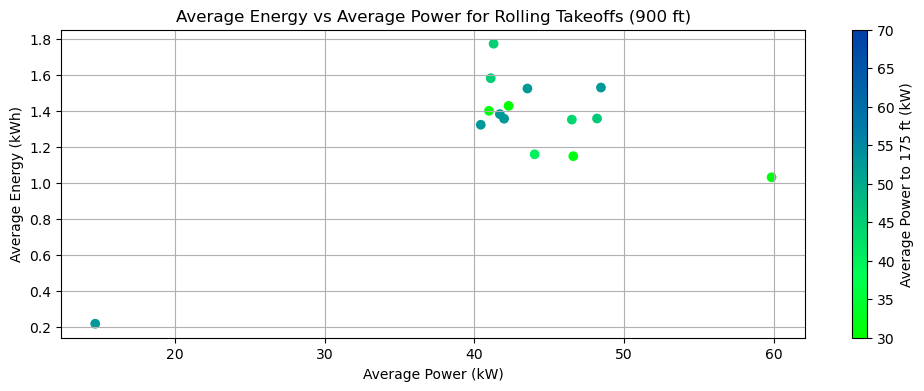

  Initial Power  Slope Linear  R Linear  Slope Exponential  R Exponential
0         40-50     -0.048094 -0.636856          -0.031458      -0.605434
1         50-60      0.041381  0.991451           0.063161       0.984701
2         60-70           NaN       NaN                NaN            NaN
CPU times: total: 1.64 s
Wall time: 4.05 s


<timed exec>:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [118]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.2, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=30, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Energy', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                plotted = True
                                initial_range = True
                                break
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                initial_range = True
                                break


                        
                        
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Initial Power"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average Power to 175 ft (kW)', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Rolling Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [40, 50, 60, 70]
labels = ['40-50', '50-60', '60-70']

df_slope['Initial Power'] = pd.cut(df_slope['Initial Power'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('Initial Power').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

### Box Plots

#### 175 ft

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


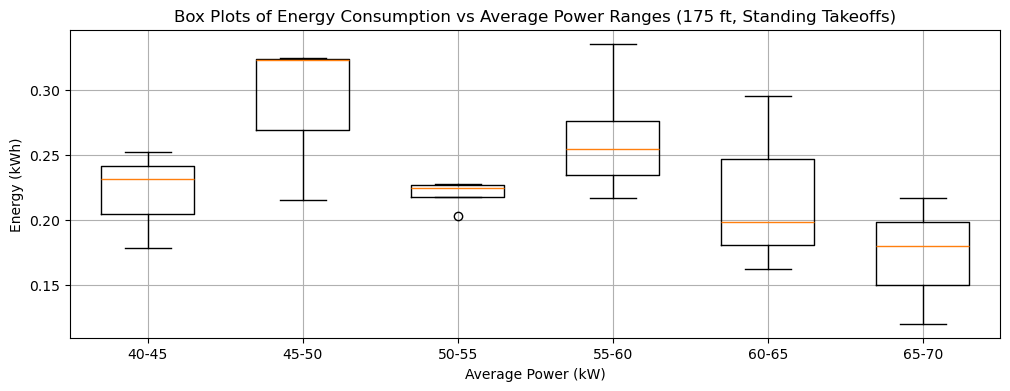

CPU times: total: 1.47 s
Wall time: 2.26 s


In [119]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Energy', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) *175 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 1 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 1 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                                


                        
                        
                                
  
print('')
print("Plotting...")

bins = [40, 45, 50, 55, 60, 65, 70]
labels = ['40-45', '45-50', '50-55', '55-60', '60-65', '65-70']


# Cut the 'Average Power' column into the specified bins
df_slope['Power Bin'] = pd.cut(df_slope['Avg Power'], bins=bins, labels=labels, right=False)


# Create box plots for each bin
data_to_plot = [df_slope[df_slope['Power Bin'] == label]['Energy'] for label in labels]

plt.boxplot(data_to_plot, labels=labels, widths=0.6)
plt.xlabel('Average Power (kW)')
plt.ylabel('Energy (kWh)')
plt.title('Box Plots of Energy Consumption vs Average Power Ranges (175 ft, Standing Takeoffs)')
plt.grid(True)
plt.show()

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


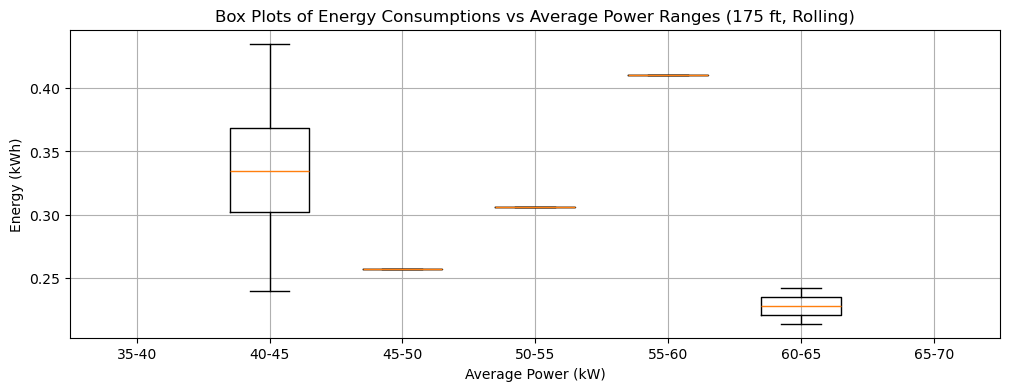

CPU times: total: 734 ms
Wall time: 2.18 s


In [120]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time','Energy', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 1 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
            
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                    
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 175 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 1 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
            
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True
                    


                        
                        
                                
  
print('')
print("Plotting...")

bins = [35, 40, 45, 50, 55, 60, 65, 70]
labels = ['35-40', '40-45', '45-50', '50-55', '55-60', '60-65','65-70']


# Cut the 'Average Power' column into the specified bins
df_slope['Power Bin'] = pd.cut(df_slope['Avg Power'], bins=bins, labels=labels, right=False)


# Create box plots for each bin
data_to_plot = [df_slope[df_slope['Power Bin'] == label]['Energy'] for label in labels]

plt.boxplot(data_to_plot, labels=labels, widths=0.6)
plt.xlabel('Average Power (kW)')
plt.ylabel('Energy (kWh)')
plt.title('Box Plots of Energy Consumptions vs Average Power Ranges (175 ft, Rolling)')
plt.grid(True)
plt.show()

In [121]:
bins = [35, 40, 45, 50, 55, 60, 65]
labels = ['35-40', '40-45', '45-50', '50-55', '55-60', '60-65']

df_slope['Average Power Range'] = pd.cut(df_slope['Avg Power'], bins=bins, labels=labels, right=False)

summary_stats = df_slope.groupby('Average Power Range')['Energy'].describe()
print(summary_stats)

                     count      mean       std       min       25%       50%  \
Average Power Range                                                            
35-40                  0.0       NaN       NaN       NaN       NaN       NaN   
40-45                  4.0  0.335823  0.080557  0.239324  0.301719  0.334400   
45-50                  1.0  0.257235       NaN  0.257235  0.257235  0.257235   
50-55                  1.0  0.305739       NaN  0.305739  0.305739  0.305739   
55-60                  1.0  0.410650       NaN  0.410650  0.410650  0.410650   
60-65                  2.0  0.227874  0.020074  0.213680  0.220777  0.227874   

                          75%       max  
Average Power Range                      
35-40                     NaN       NaN  
40-45                0.368505  0.435171  
45-50                0.257235  0.257235  
50-55                0.305739  0.305739  
55-60                0.410650  0.410650  
60-65                0.234972  0.242069  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\2834020563.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df_slope.groupby('Average Power Range')['Energy'].describe()


#### 900 ft

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


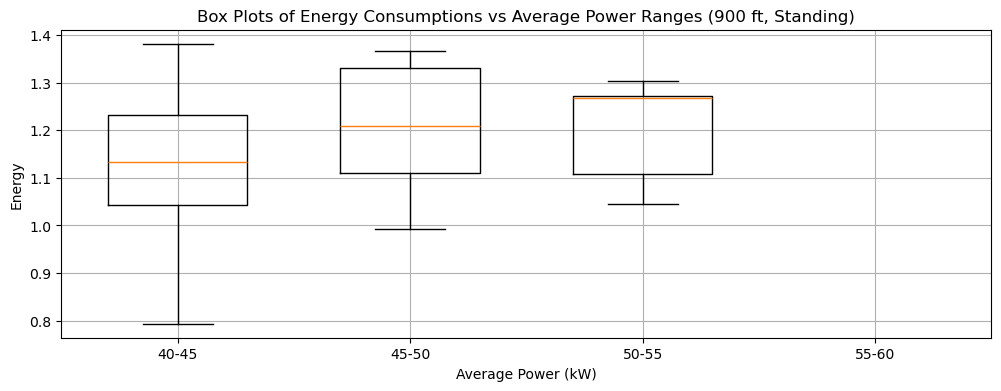

CPU times: total: 1.42 s
Wall time: 3.69 s


In [122]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Energy', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count == count_num and avg_power > 0 and end_index-start_index > 50: #
                
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                        
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count == count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
            
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True



                        
                        
                                
  
print('')
print("Plotting...")

bins = [40, 45, 50, 55, 60]
labels = ['40-45', '45-50', '50-55', '55-60']


# Cut the 'Average Power' column into the specified bins
df_slope['Power Bin'] = pd.cut(df_slope['Avg Power'], bins=bins, labels=labels, right=False)


# Create box plots for each bin
data_to_plot = [df_slope[df_slope['Power Bin'] == label]['Energy'] for label in labels]
plt.grid(True)
plt.boxplot(data_to_plot, labels=labels, widths=0.6)
plt.xlabel('Average Power (kW)')
plt.ylabel('Energy')
plt.title('Box Plots of Energy Consumptions vs Average Power Ranges (900 ft, Standing)')
plt.show()

Processing file data/vancouver/flight/csv-25030-5911_may02_0126am_dc [4%]

Processing file data/vancouver/flight/dcsv-26330-6353 [100%]0916pm_dc [88%]
Plotting...


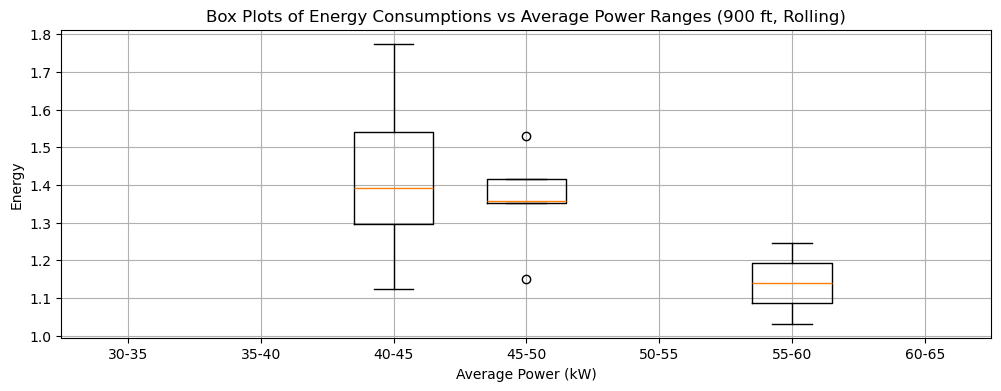

CPU times: total: 1.34 s
Wall time: 3.8 s


In [123]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time','Energy', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 225)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0 and end_index-start_index > 50: #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        plotted = True
                        initial_range = True
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0 and end_index-start_index > 50: #Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope,"Energy": avg_power*time_alt_slope/60, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                        # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                        initial_range = True



                        
                        
                                
  
print('')
print("Plotting...")

bins = [30, 35, 40, 45, 50, 55, 60, 65]
labels = ['30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65']


# Cut the 'Average Power' column into the specified bins
df_slope['Power Bin'] = pd.cut(df_slope['Avg Power'], bins=bins, labels=labels, right=False)


# Create box plots for each bin
data_to_plot = [df_slope[df_slope['Power Bin'] == label]['Energy'] for label in labels]
plt.grid(True)
plt.boxplot(data_to_plot, labels=labels, widths=0.6)
plt.xlabel('Average Power (kW)')
plt.ylabel('Energy')
plt.title('Box Plots of Energy Consumptions vs Average Power Ranges (900 ft, Rolling)')
plt.show()